# `numpy.linalg.solve` as solver

## From [2013-12-03-Crank_Nicolson](http://nbviewer.ipython.org/github/waltherg/notebooks/blob/master/2013-12-03-Crank_Nicolson.ipynb)

## Works with Python 3.7. 2020/07/09.
### Save as `Diffusion.ipynb`? What's different?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, numpy
from scipy.interpolate import interp1d

In [3]:
numpy.set_printoptions(precision=3)

In [4]:
def plot_profiles(U_record,t_grid,x_grid,nn = 10,save = 0):
    plt.xlabel('x'); plt.ylabel('concentration')
    tt = np.linspace(0+T/float(nn),T-T/float(nn),nn)
    plot(x_grid, U_record[0],'k.',label = 't = %.1f'% t_grid[0],lw = 2)
    color_idx = np.linspace(0,1,nn)
    for ij, t1 in enumerate(tt):
        plot(x_grid, U_record[int(t1/dt)],
             label = 't = %.2f'% t_grid[int(t1/dt)],
             color=plt.cm.jet(color_idx[ij]))

    plot(x_grid, U_record[-1],'k--',label = 't = %.1f'% t_grid[-1],lw = 2)
    #legend(framealpha = 0.8)
    margins(0.1)
    pth = os.path.join(os.path.expanduser('~'),'Desktop','diff_profile%s.png'%suffix)
    if save: plt.savefig(pth,bbox_inches = 'tight', dpi = 300)
    else: plt.show()
    return

def plot_fluxes(U_record,t_grid,save=0):
    U_r = np.array(U_record)
    try: 
        plot(t_grid,U_r[:,-1]**2*k_d,label = 'out')
    except:
        plot(t_grid,U_r[1]**2*k_d,label = 'out')
    #plot(t_grid,U_r[:,0]**2*k_u,label = 'input')
    legend(framealpha = 0.8)
    plt.margins(0.1)
    pth = os.path.join(os.path.expanduser('~'),'Desktop','diff_fluxes%s.png'%suffix)
    if save: plt.savefig(pth,bbox_inches = 'tight', dpi = 300)
    else: plt.show()
    return

In [5]:
def run(g_inc,U,D,k_u,k_d,sigma):
    ff = interp1d(g_inc[:,0],g_inc[:,1])
    g_inc = ff(t_grid)

    def f_vec(U,ti):
        upstream =  -D/(2.*k_u*dx) + \
        0.5*sqrt((D/(k_u*dx))**2 + 4*D*U[1]/(k_u*dx) + 4*g_inc[ti-1]/k_u)
        downstream = -D/(2.*k_d*dx) + \
        0.5*sqrt((D/(k_d*dx))**2 + 4*D*U[-2]/(k_d*dx))
        vivec = np.array([0. for ii in range(J)])
        vivec[0] = upstream; vivec[-1] = downstream
        return vivec

    A = numpy.diagflat([-sigma for i in range(J-1-1)]+[0.], -1) +\
          numpy.diagflat([1.]+[1.+2.*sigma for i in range(J-2)]+[1.]) +\
          numpy.diagflat([0.]+[-sigma for i in range(J-1-1)], 1)

    B = numpy.diagflat([sigma for i in range(J-1-1)]+[0.], -1) +\
          numpy.diagflat([0.]+[1.-2.*sigma for i in range(J-2)]+[0.]) +\
          numpy.diagflat([0.]+[sigma for i in range(J-1-1)], 1)

    U_record = []
    U_record.append(U)
    #U_record.append([U[0],U[-1]])
    for ti in range(1,N):
        #U_new = tridag(a,b,c,np.dot(B_u,U)+ff) # my tridiag method
        U_new = numpy.linalg.solve(A, B.dot(U)+f_vec(U,ti)) #numpy Gauss
        U = U_new
        U_record.append(U)
        #U_record.append([U[0],U[-1]])
    return U_record

9.001e-02:	dt
2.517e+01:	sigma


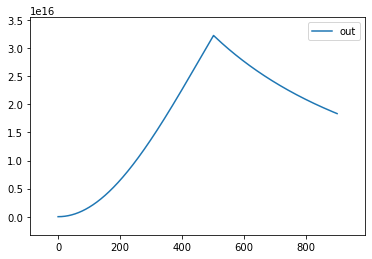

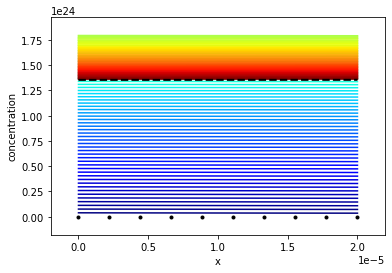

In [6]:
L = 20e-6;'m'; J = 10
T = 900;'sec'; N = 10000

dx = float(L)/float(J-1) # Grid step
x_grid = numpy.array([j*dx for j in range(J)]) # Spatial Grid
dt = float(T)/float(N-1) # Time step
t_grid = numpy.array([n*dt for n in range(N)]) # Time grid
print ('%.3e:\tdt'% dt)
T_membrane = 573.0
D=2.9e-7*exp(-0.23*1.6e-19/(1.38e-23*T_membrane)) # Diffusion coeffitient for U
sigma = float(D*dt)/float((2.*dx*dx))
print( '%.3e:\tsigma'% sigma)
k_u = 1e-31; k_d = 1e-32
suffix = '_%.0e_s'%dt
U = np.array([0.0 for i in range(J)])
end = 500.; flux = 1e18
g_inc = np.array([[-1,0],[0,0],[0.01,flux],[end,flux],[end+1,0],[901,0]])

#%prun
U_record = run(g_inc,U,D,k_u,k_d,sigma)
plot_fluxes(U_record,t_grid,save=0)
plot_profiles(U_record,t_grid,x_grid,nn = 100,save = 1)